# Вебинар 4. Рекоммендательные системы. Поиск похожих товаров и пользователей

---

### 1. Общие

ALS
- На вход принимает только *позитивные* взаимодействия
- Прогнозирует **не** вероятность, а некоторые числа
- В ALS нельзя добавить внешние фичи
- ALS не учитывает сезонность / зависимость во времени (но это можно частично поправить - см далее)
- Можно использовать для ранжирования (как - см далее + вебинар 5)

### 2. Что на самом деле оптимизирует ALS

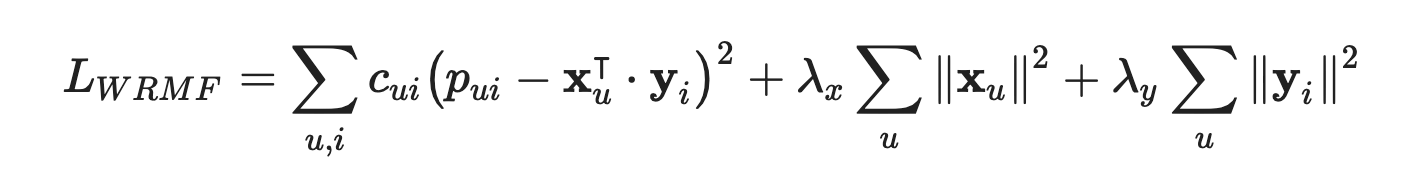

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Что делает ALS**
- Максимизирует скалярное произведение (dot product) между векторами user-item для позитивных interactions, минимизирует для негативных

**Скалярное призведение (dot product) VS косинусная схожесть (cosine similarity)**

$$dot(a, b) = a * b$$  
  
$$cos(a, b) = \frac{a * b}{||a||*||b||} = \frac{dot(a, b)}{||a||*||b||}$$

### 3. Как учитывать изменение вкусов потребителей во времени / изменение популярности товара во времени

- Летом юзеры любят мороженое, а зимой - нет
- Многие фильмы популярны во время проката в кино, затем их популярность снижается

*Что делать?*  
Ограничить давность взаимодейстий.  
Давать последним взаимодействиям больший вес:  

$$value_w = \sum_i value_i * \frac{1}{1 + \exp^{ \alpha*t}}$$

### 4. Как использовать для ранжирования (Краткое введение. Подробности - на следующем вебинаре)

**Вариант 1.**  
*As is* - ранжировать по output ALS

**Вариант 2.**
*Та же модель, другой лосс - BPR*

BPR - Bayesian Personalized Ranking loss
1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p_{ui}$, $p_{uj}$ --> $p_{ui} - p_{uj}$
4. loss = $\sigma(p_{ui} - p_{uj})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

Синтаксис такой же как у AlternatingLeastSquares. ML модель такая же, лосс - BPR

---

In [14]:
# !pip install implicit==0.4.4 

In [13]:
# (implicit==0.4.8)

In [1]:
#from implicit.bpr import BayesianPersonalizedRanking


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
#from implicit.als import AlternatingLeastSquares
#from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
#from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from metrics import precision_at_k, recall_at_k

In [3]:
data = pd.read_csv('../webinar_2/retail_train.csv')

In [4]:
print(data.shape)
data.head(3)

(2396804, 12)


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [4]:
#data.columns = [col.lower() for col in data.columns]
#data.rename(columns={'household_key': 'user_id','product_id': 'item_id'}, inplace=True)
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [18]:
data_train[data_train['item_id']==1004906].groupby('quantity')['sales_value'].unique()

quantity
0                                                [0.0]
1    [1.39, 1.99, 1.79, 1.81, 1.0, 1.89, 1.5, 1.49,...
2    [2.0, 3.78, 3.98, 2.99, 2.69, 5.98, 3.0, 5.58,...
3                                          [3.0, 4.47]
4                                          [4.0, 5.98]
5                                                [5.0]
Name: sales_value, dtype: object

In [32]:
data_train[(data_train['item_id']==1004906) & (data_train['quantity']==3)]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
131753,1561,28069082297,91,1004906,3,3.00,358,-2.97,1858,14,0.0,0.0
143995,263,28110794132,95,1004906,3,3.00,319,-2.97,2110,14,0.0,0.0
2105671,1954,40618562895,593,1004906,3,4.47,339,-4.50,2001,85,0.0,0.0


In [34]:
data_train['quantity'].value_counts().sort_index() #sort_values() #ascending=False) #'quantity', )

0          12694
1        1800809
2         326012
3          58869
4          33760
          ...   
48073          1
51912          1
61335          1
85055          1
89638          1
Name: quantity, Length: 10939, dtype: int64

In [40]:
data_train[data_train['quantity']==89638]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
1750942,630,34749153595,503,6534178,89638,250.0,384,-13.45,1927,73,0.0,0.0


In [43]:
aaa=data_train[data_train['item_id']==6534178]

In [47]:
aaa.sort_values(by='quantity')

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
1348534,957,32957765080,404,6534178,10,0.03,319,-0.01,739,58,0.0,0.0
1474445,172,33397554280,434,6534178,13,0.04,372,-0.01,2310,63,0.0,0.0
673944,638,30578645392,235,6534178,16,0.03,361,-0.01,2228,34,0.0,0.0
2264367,1010,41238662706,632,6534178,25,0.06,341,-0.01,2225,91,0.0,0.0
2271612,1146,41259684958,635,6534178,27,0.06,319,-0.01,102,91,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1560340,149,33768630428,456,6534178,41833,115.00,327,-4.18,1059,66,0.0,0.0
1340882,193,32956767959,402,6534178,48073,121.10,310,-7.21,1825,58,0.0,0.0
166536,149,28210551971,103,6534178,51912,110.00,327,-5.19,1514,15,0.0,0.0
481876,630,29484790880,185,6534178,61335,150.21,384,-6.13,1056,27,0.0,0.0


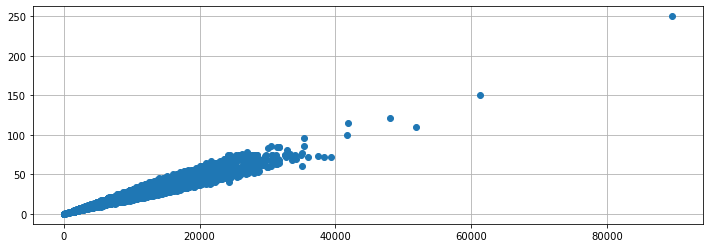

In [61]:
x=aaa['quantity']
y=aaa['sales_value']
#x=aaa['day']
#y=aaa['week_no']
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x, y,marker='o', ms=6,linestyle='')
plt.grid()
plt.show()

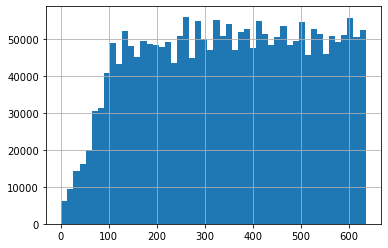

In [57]:
data_train['day'].hist(bins=50);

In [5]:
item_features = pd.read_csv('../webinar_2/product.csv')
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [8]:
n_items_before = data_train['item_id'].nunique()
n_items_before #количество уникальных товаров

86865

In [9]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999_999

In [10]:
n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


In [11]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [13]:
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

AttributeError: head not found

In [14]:
user_item_matrix_bm25

<2499x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 667080 stored elements in COOrdinate format>

In [15]:
# function for recommend: получаем id товаров рекоммендованых пользователю user
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix_bm25).tocsr(),   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999_999]],  # !!! 
                                    recalculate_user=False)]
    return res

In [16]:
%%time

model = BayesianPersonalizedRanking(factors=64, 
                                regularization=0.05,
                                learning_rate=0.01,
                                iterations=50, 
                                num_threads=60)

model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 21.7 s, sys: 0 ns, total: 21.7 s
Wall time: 35.9 s


In [17]:
%%time
result['bpr_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

print("Precision:", result.apply(lambda row: precision_at_k(row['bpr_bm25'], row['actual']), axis=1).mean())

Precision: 0.17649363369245838
CPU times: user 38.4 s, sys: 0 ns, total: 38.4 s
Wall time: 56 s


In [18]:
%%time

model = AlternatingLeastSquares(factors=64, 
                                regularization=0.05,
                                iterations=50, 
                                calculate_training_loss=True, 
                                num_threads=60,
                                use_gpu=False)

model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 23.1 s, sys: 0 ns, total: 23.1 s
Wall time: 30.1 s


In [19]:
%%time
result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

print("Precision:",result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())

Precision: 0.12105778648383939
CPU times: user 36.6 s, sys: 0 ns, total: 36.6 s
Wall time: 41.5 s


In [20]:
result.head(10)

,user_id,actual,bpr_bm25,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 1127831, 962568, 961554, 878996]","[1100972, 10282046, 1051211, 9445549, 1022097]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[883404, 1098066, 826249, 1106523, 1082185]","[1110244, 951590, 844839, 879504, 913278]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 962568, 981760, 878996, 1127831]","[1051516, 866211, 878996, 1127179, 895268]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1082185, 981760, 995242, 6534178, 1127831]","[1121393, 857390, 1123086, 1031833, 1003188]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1082185, 981760, 995242, 826249, 1098066]","[873916, 840361, 945456, 866355, 1093359]"
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1082185, 981760, 883404, 1098066, 995242]","[1056005, 893018, 862799, 1039126, 1058021]"
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884...","[1082185, 826249, 1029743, 1098066, 995242]","[1014948, 7167945, 1069635, 12256522, 1011578]"
7,14,"[840601, 867293, 933067, 951590, 952408, 96569...","[883404, 1082185, 1106523, 1098066, 1044078]","[969205, 1113588, 1008673, 907128, 1122358]"
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13...","[1082185, 1127831, 981760, 962568, 878996]","[933637, 866871, 878996, 1053530, 863632]"
9,16,"[1062973, 1082185, 13007710]","[1082185, 981760, 995242, 1127831, 1098066]","[6410462, 1084551, 1023473, 923149, 5582712]"


----

# Альтернативные способы предсказаний

### Кейс 1. Продажи товаров собственной торговой марки (СТМ)

У многих ритейлеров есть товары СТМ:
    - Азбука Вкуса - Просто Азбука
    - Ашан - Каждый день
    - ВкусВилл - ВкусВилл
    - ...
    
Как правило, у них маржинальность (~прибыль) > обычные товары.   
Как сделать так, чтобы юзеры переключились на товары СТМ? - *рекоммендации!*

*Нужно заменить те товары, которые пользователь уже покупает, на товары СТМ*

In [88]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
2820,202291,69,MISC SALES TRAN,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,
3565,397896,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [21]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [22]:
# фильтранем на всякий случай
item_features = item_features[item_features['item_id'].isin(itemid_to_id.keys())]

In [23]:
# кол-во товаров СТМ
item_features[item_features['brand'] == 'Private'].item_id.nunique()

1464

In [24]:
own_items = item_features[item_features['brand'] == 'Private'].groupby('department')['item_id'].nunique().\
sort_values(ascending=False)

In [25]:
own_items

department
GROCERY            1229
MEAT-PCKGD           74
PRODUCE              32
PASTRY               31
DELI                 25
MISC SALES TRAN      20
DRUG GM              14
KIOSK-GAS            13
SEAFOOD-PCKGD        12
MEAT                  8
NUTRITION             5
FLORAL                1
Name: item_id, dtype: int64

In [26]:
categories_with_own_items = own_items.index.tolist()
categories_with_own_items

['GROCERY',
 'MEAT-PCKGD',
 'PRODUCE',
 'PASTRY',
 'DELI',
 'MISC SALES TRAN',
 'DRUG GM',
 'KIOSK-GAS',
 'SEAFOOD-PCKGD',
 'MEAT',
 'NUTRITION',
 'FLORAL']

In [31]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=0.1, random_state=42, n_iter=3000, n_iter_without_progress=20)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [32]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [34]:
len(category)

5001

## Reduce size of item matrix

In [35]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne')

/home/roman/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


CPU times: user 24.5 s, sys: 980 ms, total: 25.5 s
Wall time: 31 s


In [37]:
print(item_emb_tsne.shape)
item_emb_tsne.head(3)

(5001, 2)


,component_1,component_2
0,-1.234510e-07,-2.911639e-07
1,1.648304e-06,1.519973e-06
2,8.461173e-08,1.494227e-07


In [38]:
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne['item_id'] = list(itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']
item_emb_tsne.head(3)

,component_1,component_2,category,item_id
0,-1.234510e-07,-2.911639e-07,MISC SALES TRAN,202291
1,1.648304e-06,1.519973e-06,KIOSK-GAS,397896
2,8.461173e-08,1.494227e-07,MISC SALES TRAN,420647


In [39]:
item_emb_tsne.shape

(5000, 4)

### Display all points

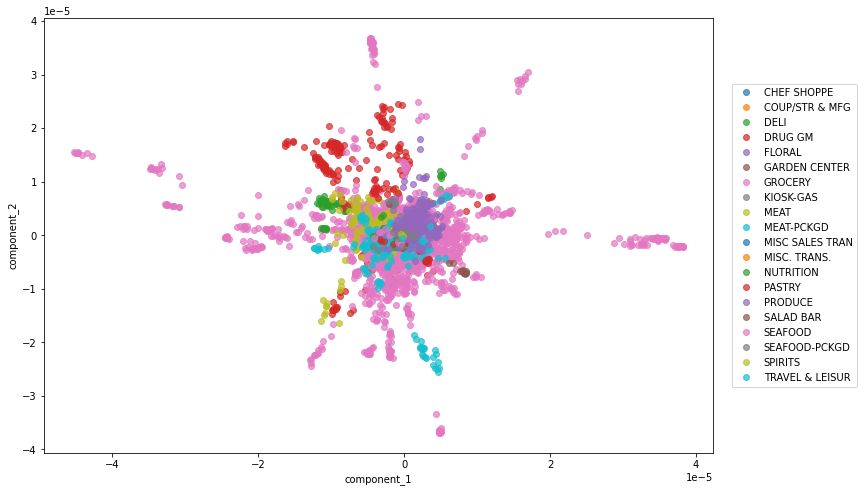

In [40]:
display_components_in_2D_space(item_emb_tsne, labels='category')

### Delete category "GROCERY"

In [41]:
item_emb_tsne_reduced = item_emb_tsne[item_emb_tsne['category'] != 'GROCERY']

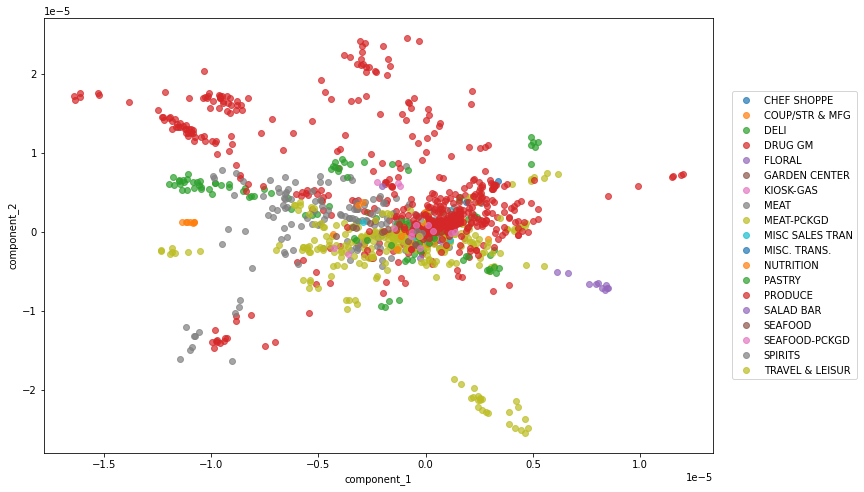

In [42]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

### Нарисуем все товары в категориях, где есть СТМ

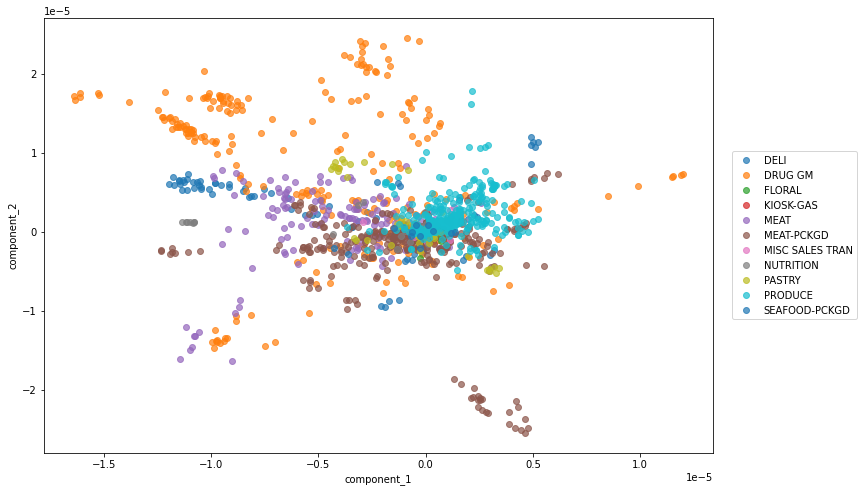

In [43]:
display_components_in_2D_space(item_emb_tsne_reduced[item_emb_tsne_reduced['category'].isin(categories_with_own_items)], 
                               labels='category')

### Найдем похожие, и отрисуем

In [44]:
itemid_to_id[1004906]

2434

In [45]:
similar_items = model.similar_items(itemid_to_id[1004906], N=50)

In [48]:
print(len(similar_items))
similar_items[:5]

50


[(2434, 1.0),
 (1111, 0.7235345),
 (1809, 0.72095525),
 (2965, 0.6403225),
 (2927, 0.61270636)]

In [49]:
similar_items = [id_to_itemid[sim[0]] for sim in similar_items]

In [52]:
print(len(similar_items))
similar_items[:10]

50


[1004906,
 899624,
 952163,
 1046545,
 1044078,
 995785,
 844179,
 904360,
 845208,
 1068719]

In [150]:
#similar_items.append(1004906)

In [53]:
item_emb_tsne[item_emb_tsne['item_id'] == 1004906]

,component_1,component_2,category,item_id
2434,-4.837638e-07,-1.574915e-07,PRODUCE,1004906


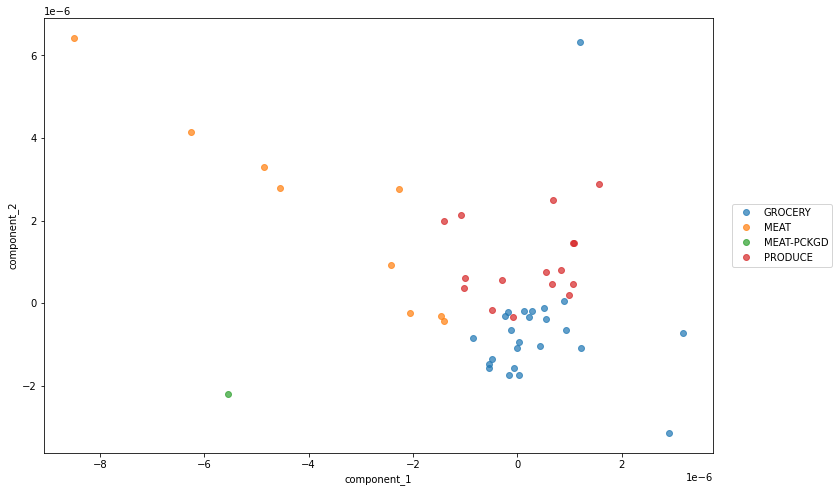

In [54]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)], 
                               labels='category')

In [61]:
item_emb_tsne[(item_emb_tsne['category'] == 'MEAT') & (item_emb_tsne['item_id'].isin(similar_items))]

,component_1,component_2,category,item_id
95,-0.000005,3.307811e-06,MEAT,825343
137,-0.000005,2.777869e-06,MEAT,828106
340,-0.000001,-4.372609e-07,MEAT,844179
851,-0.000002,2.765423e-06,MEAT,880150
1065,-0.000006,4.146656e-06,MEAT,896613
1349,-0.000002,9.207423e-07,MEAT,916122
1574,-0.000008,6.425219e-06,MEAT,934639
2378,-0.000002,-2.343471e-07,MEAT,999858
2927,-0.000001,-3.037031e-07,MEAT,1044078


#### Берем топ-5 популярных покупок юзера --> находим по 1 наиболее близкому товару СТМ для них --> рекомендуем

In [62]:
# your_code
popularity = data_train.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()

In [63]:
popularity

,user_id,item_id,quantity
0,1,820165,2
1,1,823721,1
2,1,823990,1
3,1,826695,2
4,1,827656,1
...,...,...,...
667075,2500,13512060,2
667076,2500,13842088,1
667077,2500,13842224,1
667078,2500,15511891,1


In [64]:
popularity.sort_values('quantity', ascending=False, inplace=True)
popularity

,user_id,item_id,quantity
616143,2322,999999,2926
382540,1453,999999,2659
628712,2364,999999,2513
654420,2459,999999,2341
191180,718,999999,2249
...,...,...,...
360935,1367,930666,1
360934,1367,930553,1
360933,1367,930118,1
131381,504,1070015,1


In [65]:
popularity = popularity[popularity['item_id'] != 999_999]
popularity

,user_id,item_id,quantity
621588,2337,1120741,228
224324,853,975938,220
272935,1023,6533889,206
397616,1510,1126203,205
397310,1510,894236,203
...,...,...,...
360935,1367,930666,1
360934,1367,930553,1
360933,1367,930118,1
131381,504,1070015,1


In [66]:
popularity = popularity.groupby('user_id').head(5)
popularity

,user_id,item_id,quantity
621588,2337,1120741,228
224324,853,975938,220
272935,1023,6533889,206
397616,1510,1126203,205
397310,1510,894236,203
...,...,...,...
358527,1355,1075214,1
131969,509,847982,1
131443,505,1014802,1
131444,505,1038325,1


In [67]:
popularity.sort_values(by=['user_id','quantity'], ascending=False, inplace=True)
popularity.head(10)

/tmp/ipykernel_3430/3667164642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popularity.sort_values(by=['user_id','quantity'], ascending=False, inplace=True)


,user_id,item_id,quantity
666942,2500,1082185,21
666703,2500,859237,16
667027,2500,6534178,12
666919,2500,1065538,10
666913,2500,1058997,9
666545,2499,1070820,24
666268,2499,826249,10
666616,2499,5568378,8
666470,2499,999971,7
666415,2499,944317,7


In [68]:
%%time

def get_rec_similar_items(model, x):
    recs = model.similar_items(itemid_to_id[x], N=2)
    top_rec = recs[1][0]
    return id_to_itemid[top_rec]
    

popularity['similar_recommendation'] = popularity['item_id'].apply(lambda x: get_rec_similar_items(model, x))
popularity.head(5)

CPU times: user 2.3 s, sys: 5.21 ms, total: 2.31 s
Wall time: 3.37 s


<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,user_id,item_id,quantity,similar_recommendation
666942,2500,1082185,21,999999
666703,2500,859237,16,991951
667027,2500,6534178,12,999999
666919,2500,1065538,10,1034176
666913,2500,1058997,9,1126899


In [69]:
recommendation_similar_items = popularity.groupby('user_id')['similar_recommendation'].unique().reset_index()
recommendation_similar_items.columns=['user_id', 'similar_recommendation']
recommendation_similar_items.head(2)

,user_id,similar_recommendation
0,1,"[987237, 999999, 1029743, 826597, 880579]"
1,2,"[1106523, 1133018, 1137346, 1021324, 985999]"


In [70]:
result_predict = result.merge(recommendation_similar_items, on='user_id', how='inner')
result_predict.head(2)

,user_id,actual,bpr_bm25,als_bm25,similar_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 1127831, 962568, 961554, 878996]","[1100972, 10282046, 1051211, 9445549, 1022097]","[987237, 999999, 1029743, 826597, 880579]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[883404, 1098066, 826249, 1106523, 1082185]","[1110244, 951590, 844839, 879504, 913278]","[9396770, 909396, 883932, 1075979, 1133018]"


In [71]:

from metrics import precision_at_k

# result.apply(lambda row: precision_at_k(row['similar_recommendation'], row['actual']), axis=1).mean()
result_predict.apply(lambda row: precision_at_k(row['similar_recommendation'], row['actual']), axis=1).mean()

0.11621665848469973

### Кейс 2. Вашим друзьям нравится / Похожим пользователям нравится / ...

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [72]:
userid_to_id[10]

9

In [74]:
similar_users_ = model.similar_users(userid_to_id[10], N=6) #нашли похожих пользователей

In [75]:
similar_users_

[(9, 0.99999994),
 (1765, 0.65191907),
 (1552, 0.6059407),
 (1671, 0.5812083),
 (609, 0.55064595),
 (1549, 0.54612386)]

In [76]:
%%time
own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей
own.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(), show_progress=True)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: user 1.83 s, sys: 36.1 ms, total: 1.87 s
Wall time: 6.09 s


In [77]:
recs = model.recommend(userid=userid_to_id[1], 
                       user_items=csr_matrix(user_item_matrix_bm25).tocsr(),   # на вход user-item matrix
                       N=5, 
                       filter_already_liked_items=False, 
                       filter_items=None, 
                       recalculate_user=False)

In [78]:
recs

[(3616, 1.2537737),
 (4800, 1.1509591),
 (3031, 1.074784),
 (4622, 1.0336096),
 (2666, 1.0225296)]

In [79]:
get_recommendations(user=1, model=own, N=1)

[856942]

In [81]:
id_to_itemid[3616]     

1100972

In [ ]:
model.similar_users()

In [ ]:
item1 = image = vector1, dot_product(vector1,vectorN)=score
item1 = title(заголовок) = vector1 

# Стандартные Content-based 

- по картинкам

- по текстам (описания товаров, комментарии, заголовки)

Получаем вектора по-любому контенту и дальше считаем KNN

# Production

In [ ]:
def prefilter_items(data):
    # Уберем товары, которые не продавались за последние 12 месяцев
    day_max=data['day'].max()
    data['dday']=day_max-data['day']
    del_day=data[data['dday']>365].index.tolist() #индексы строк для удаления
    data=data.loc[~data.index.isin(del_day)] #
    
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
    top_500 = popularity.sort_values('n_sold', ascending=False).head(500).item_id.tolist()
    tail_500=popularity.sort_values('n_sold', ascending=False).tail(500).item_id.tolist()
    data=data.loc[~data['item_id'].isin(top_500)]
        
    # Уберем не интересные для рекоммендаций категории (department)
    data=data.loc[~data['item_id'].isin(tail_500)]
    
    pop = data.groupby('item_id')['sales_value'].sum()
    pop1 = data.groupby('item_id')['quantity'].sum()
    dd=pd.merge(pop,pop1,on='item_id')
    dd=dd[dd['quantity']>0]
    dd['prc']=dd['sales_value']/dd['quantity']
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    item_id_prcmin=dd[dd['prc']<0.5].index
    data=data.loc[~data['item_id'].isin(item_id_prcmin)]
    # Уберем слишком дорогие товары . их наверно покупают мало
    item_id_prcmax=dd[dd['prc']>100].index
    data=data.loc[~data['item_id'].isin(item_id_prcmax)]                                    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

In [41]:
from pandas import Series

In [ ]:
def get_rec_similar_items(model, x):
    recs = model.similar_items(itemid_to_id[x], N=2)
    top_rec = recs[1][0]
    return id_to_itemid[top_rec]

In [ ]:
def get_recommendations(user, model, sparse_user_item, N=5):
    """Рекомендуем топ-N товаров"""
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [ ]:
def get_similar_items_recommendation(user, model, N=5):
    """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
    df=data[data['user_id']==user
    pop_df=df.groupby(['item_id'])['quantity'].count.reset_index()
    pop_df.sort_values(by='quantity',ascending=False, inplace=True)
    pop_df=pop_df[pop_df['item_id']!=999_999]
    pop_df=pop_df.head(N)
    pop_df['sim_rec']=pop_df['item_id'].apply(lambda x: get_rec)similar_items(model=model,x)
    res=pop_df['sim_rec'].tolist()
    return res

In [ ]:
def get_similar_users_recommendation(user, model, N=5):
    """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
    
    sim_users_ = model.similar_users(usersid_to_id[user], N=N+1)
    sim_users_=sim_users_[1:]
    own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей
    own.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(), show_progress=False) #True)
    res=[]
    for us in sim_users_:
        recs = own.recommend(userid=userid_to_id[us[0]],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_bm25).tocsr(),   # на вход user-item matrix
                        N=1, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)
        
        #it=get_recommendations(user=us[0], model=own, N=1)
        res.append(id_to_itemid[recs[0]])
    
    return res

----

In [2]:
import numpy as np

In [4]:
msv=[(3616, 1.2537737),
 (4800, 1.1509591),
 (3031, 1.074784),
 (4622, 1.0336096),
 (2666, 1.0225296)]
msv

[(3616, 1.2537737),
 (4800, 1.1509591),
 (3031, 1.074784),
 (4622, 1.0336096),
 (2666, 1.0225296)]